# Design Project 3: Drone Code 
Ishaan Kandamuri

 ## Dynamics and Sensor Model
 The below section is pulled from ae353-EoM.ipynb

In [2]:
from sympy import * 
import sympy as sym
import numpy as np
from scipy import linalg
import matplotlib.pyplot as plt
import ae353_quadrotor
init_printing()

pybullet build time: Sep  3 2024 12:57:43


In [3]:
# Get the gravity in m/s^2
from ae353_quadrotor import get_gravity
planet = "Earth"
grav = get_gravity(planet, verbose=True)

In [4]:
# Mass and moment of inertia of the bus
mass = 0.5    # The mass of the quadrotor in kg
Ixx = 0.0023  # The moment of inertia of the quadrotor in 
Iyy = 0.0023  # The mass of the quadrotor in kg
Izz = 0.0040  # The mass of the quadrotor in kg
lxy = 0.25    # The x or y distance from the quadrotor frame to the mocap markers in meters
lz = 0.046875 # The z distance from the quadrotor frame to the mocap markers in meters

In [5]:
# Define position
px_inW, py_inW, pz_inW = sym.symbols('p_x, p_y, p_z')
p_inW = sym.Matrix([[px_inW],
                    [py_inW],
                    [pz_inW]])

# Define velocity
vx_inB, vy_inB, vz_inB = sym.symbols('v_x, v_y, v_z')
v_inB = sym.Matrix([[vx_inB],
                    [vy_inB],
                    [vz_inB]])

# Define roll (phi), pitch (theta), and yaw (psi) angles
phi, theta, psi = sym.symbols('phi, theta, psi')

# Define angular velocities
wx_inB, wy_inB, wz_inB = sym.symbols('omega_x, omega_y, omega_z')
w_inB = sym.Matrix([[wx_inB],
                    [wy_inB],
                    [wz_inB]])

# Define roll, pitch, and yaw rotation matrices that describe the bus's orientation in the 
# world frame
Rx = sym.Matrix([[1,            0,             0],
                 [0, sym.cos(phi), -sym.sin(phi)],
                 [0, sym.sin(phi),  sym.cos(phi)]])
Ry = sym.Matrix([[ sym.cos(theta), 0, sym.sin(theta)],
                 [              0, 1,              0],
                 [-sym.sin(theta), 0, sym.cos(theta)]])
Rz = sym.Matrix([[sym.cos(psi), -sym.sin(psi), 0],
                 [sym.sin(psi),  sym.cos(psi), 0],
                 [           0,             0, 1]])
R_ofB_inW = Rz @ Ry @ Rx
R_ofW_inB = R_ofB_inW.T

In [6]:
# Define inputs
taux_inB, tauy_inB, tauz_inB, fz_inB = sym.symbols('tau_x, tau_y, tau_z, f_z')

# Get the net torque vector
tau_inB = sym.Matrix([[taux_inB],
                      [tauy_inB],
                      [tauz_inB]])
tau_inB = sym.simplify(tau_inB)

# Get the gravity force and convert to body coordiantes
grav_inW = sym.Matrix([[0.],
                       [0.],
                       [-mass * grav]])
grav_inB = R_ofW_inB @ grav_inW

# Get the net force vector
f_inB = grav_inB + sym.Matrix([[0.],
                               [0.],
                               [fz_inB]])
f_inB = sym.simplify(f_inB)

In [7]:
# Assemble the moment of inertia matrix
I_inB = sym.Matrix([[Ixx, 0.,  0.],
                    [0.,  Iyy, 0.],
                    [0.,  0.,  Izz]])

In [8]:
v_inW = R_ofB_inW @ v_inB
xyz_dot = sym.simplify(v_inW)
print("px, py, pz rate as a function of orientation and body-fixed velocities:")
sym.N(xyz_dot,3)

px, py, pz rate as a function of orientation and body-fixed velocities:


⎡vₓ⋅cos(ψ)⋅cos(θ) + v_y⋅(sin(φ)⋅sin(θ)⋅cos(ψ) - sin(ψ)⋅cos(φ)) + v_z⋅(sin(φ)⋅s ↪
⎢                                                                              ↪
⎢vₓ⋅sin(ψ)⋅cos(θ) + v_y⋅(sin(φ)⋅sin(ψ)⋅sin(θ) + cos(φ)⋅cos(ψ)) - v_z⋅(sin(φ)⋅c ↪
⎢                                                                              ↪
⎣                            -vₓ⋅sin(θ) + v_y⋅sin(φ)⋅cos(θ) + v_z⋅cos(φ)⋅cos(θ ↪

↪ in(ψ) + sin(θ)⋅cos(φ)⋅cos(ψ))⎤
↪                              ⎥
↪ os(ψ) - sin(ψ)⋅sin(θ)⋅cos(φ))⎥
↪                              ⎥
↪ )                            ⎦

In [9]:
v_inB_dot = (1 / mass) * (f_inB - w_inB.cross(mass * v_inB))
v_inB_dot = sym.simplify(v_inB_dot)
print("Body-fixed velocity rates as a function of orientation, body-fixed velocities, and applied forces:")
sym.N(v_inB_dot,3)

Body-fixed velocity rates as a function of orientation, body-fixed velocities, and applied forces:


⎡       -1.0⋅ω_y⋅v_z + 1.0⋅ω_z⋅v_y + 9.81⋅sin(θ)       ⎤
⎢                                                      ⎥
⎢     1.0⋅ωₓ⋅v_z - 1.0⋅ω_z⋅vₓ - 9.81⋅sin(φ)⋅cos(θ)     ⎥
⎢                                                      ⎥
⎣2.0⋅f_z - 1.0⋅ωₓ⋅v_y + 1.0⋅ω_y⋅vₓ - 9.81⋅cos(φ)⋅cos(θ)⎦

In [10]:
# Define the transformation that takes roll, pitch, and yaw rates to body-fixed angular rates
ex = sym.Matrix([[1], [0], [0]])
ey = sym.Matrix([[0], [1], [0]])
ez = sym.Matrix([[0], [0], [1]])
M = sym.Matrix.hstack(ex, Rx.T@ey, (Ry@Rx).T@ez)

# Invert the transformation to get a matrix that takes body-fixed angular rates to 
# roll, pitch, and yaw rates
M_inv = sym.simplify(M.inv())

# Convert the body-fixed angular rates to roll, pitch, and yaw rates
rpy_dot = sym.simplify(M_inv@w_inB)
print("Roll, pitch, and yaw rate as a function of orientation and body-fixed angular rates:")
sym.N(rpy_dot,3)

Roll, pitch, and yaw rate as a function of orientation and body-fixed angular rates:


⎡ωₓ + ω_y⋅sin(φ)⋅tan(θ) + ω_z⋅cos(φ)⋅tan(θ)⎤
⎢                                          ⎥
⎢         ω_y⋅cos(φ) - ω_z⋅sin(φ)          ⎥
⎢                                          ⎥
⎢         ω_y⋅sin(φ) + ω_z⋅cos(φ)          ⎥
⎢         ───────────────────────          ⎥
⎣                 cos(θ)                   ⎦

In [11]:
# Apply Euler's equation to get the time derivative of the angular velocities of the
# quadrotor in the quadrotor frame
w_inB_dot = I_inB.inv() @ (tau_inB - w_inB.cross(I_inB@w_inB))
w_inB_dot = sym.simplify(w_inB_dot)
print("Time derivative of the angular velocities in the body-fixed frame:")
sym.N(w_inB_dot, 3)

Time derivative of the angular velocities in the body-fixed frame:


⎡-0.739⋅ω_y⋅ω_z + 435.0⋅τₓ⎤
⎢                         ⎥
⎢0.739⋅ωₓ⋅ω_z + 435.0⋅τ_y ⎥
⎢                         ⎥
⎣        250.0⋅τ_z        ⎦

In [12]:
f = sym.Matrix.vstack(xyz_dot,
                      v_inB_dot,
                      rpy_dot,
                      w_inB_dot)

In [13]:
sym.N(f,3)

⎡vₓ⋅cos(ψ)⋅cos(θ) + v_y⋅(sin(φ)⋅sin(θ)⋅cos(ψ) - sin(ψ)⋅cos(φ)) + v_z⋅(sin(φ)⋅s ↪
⎢                                                                              ↪
⎢vₓ⋅sin(ψ)⋅cos(θ) + v_y⋅(sin(φ)⋅sin(ψ)⋅sin(θ) + cos(φ)⋅cos(ψ)) - v_z⋅(sin(φ)⋅c ↪
⎢                                                                              ↪
⎢                            -vₓ⋅sin(θ) + v_y⋅sin(φ)⋅cos(θ) + v_z⋅cos(φ)⋅cos(θ ↪
⎢                                                                              ↪
⎢                                 -1.0⋅ω_y⋅v_z + 1.0⋅ω_z⋅v_y + 9.81⋅sin(θ)     ↪
⎢                                                                              ↪
⎢                               1.0⋅ωₓ⋅v_z - 1.0⋅ω_z⋅vₓ - 9.81⋅sin(φ)⋅cos(θ)   ↪
⎢                                                                              ↪
⎢                          2.0⋅f_z - 1.0⋅ωₓ⋅v_y + 1.0⋅ω_y⋅vₓ - 9.81⋅cos(φ)⋅cos ↪
⎢                                                                              ↪
⎢                           

In [14]:
# Position of markers in body frame
mark1_inB = sym.Matrix([[lxy],
                        [0.],
                        [lz]])
mark2_inB = sym.Matrix([[0.],
                        [lxy],
                        [lz]])
mark3_inB = sym.Matrix([[-lxy],
                        [0.],
                        [lz]])
mark4_inB = sym.Matrix([[0.],
                        [-lxy],
                        [lz]])

# Position of markers in world frame
mark1_inW = p_inW + R_ofB_inW @ mark1_inB
mark2_inW = p_inW + R_ofB_inW @ mark2_inB
mark3_inW = p_inW + R_ofB_inW @ mark3_inB
mark4_inW = p_inW + R_ofB_inW @ mark4_inB

# Sensor model
g = sym.simplify(sym.Matrix.vstack(mark1_inW, mark2_inW, mark3_inW, mark4_inW))

In [15]:
sym.N(g,3)

⎡              pₓ + 0.0469⋅sin(φ)⋅sin(ψ) + 0.0469⋅sin(θ)⋅cos(φ)⋅cos(ψ) + 0.25⋅ ↪
⎢                                                                              ↪
⎢              p_y - 0.0469⋅sin(φ)⋅cos(ψ) + 0.0469⋅sin(ψ)⋅sin(θ)⋅cos(φ) + 0.25 ↪
⎢                                                                              ↪
⎢                                p_z - 0.25⋅sin(θ) + 0.0469⋅cos(φ)⋅cos(θ)      ↪
⎢                                                                              ↪
⎢pₓ + 0.0469⋅sin(φ)⋅sin(ψ) + 0.25⋅sin(φ)⋅sin(θ)⋅cos(ψ) - 0.25⋅sin(ψ)⋅cos(φ) +  ↪
⎢                                                                              ↪
⎢p_y + 0.25⋅sin(φ)⋅sin(ψ)⋅sin(θ) - 0.0469⋅sin(φ)⋅cos(ψ) + 0.0469⋅sin(ψ)⋅sin(θ) ↪
⎢                                                                              ↪
⎢                             p_z + 0.25⋅sin(φ)⋅cos(θ) + 0.0469⋅cos(φ)⋅cos(θ)  ↪
⎢                                                                              ↪
⎢              pₓ + 0.0469⋅s

## System Linearization and State Space Form

In [16]:
# Equilibrium point for linearizing the system into state space form

px_e = py_e = pz_e = vx_e = vy_e = vz_e = phi_e = theta_e = psi_e = omegax_e = omegay_e = omegaz_e = taux_e = tauy_e = tauz_e = 0.
fz_e = 4.905

m_e = np.array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0])
n_e = np.array([0, 0, 0, 4.905])


In [17]:
# Checks if the function value when plugging the equilibrium points equals to 0
f_num = lambdify([px_inW, py_inW, pz_inW, vx_inB, vy_inB, vz_inB, phi, theta, psi, wx_inB, wy_inB, wz_inB, taux_inB, tauy_inB, tauz_inB, fz_inB], f)
f_eq = f_num(px_e, py_e, pz_e, vx_e, vy_e, vz_e, phi_e, theta_e, psi_e, omegax_e, omegay_e, omegaz_e, taux_e, tauy_e, tauz_e, fz_e)
Matrix(f_eq)

⎡0.0⎤
⎢   ⎥
⎢0.0⎥
⎢   ⎥
⎢0.0⎥
⎢   ⎥
⎢0.0⎥
⎢   ⎥
⎢0.0⎥
⎢   ⎥
⎢0.0⎥
⎢   ⎥
⎢0.0⎥
⎢   ⎥
⎢0.0⎥
⎢   ⎥
⎢0.0⎥
⎢   ⎥
⎢0.0⎥
⎢   ⎥
⎢0.0⎥
⎢   ⎥
⎣0.0⎦

In [18]:
# Solve for Coefficient Matrix A by taking the Jacobian of the dynamic model function with respect to the state variables

A_num = lambdify([px_inW, py_inW, pz_inW, vx_inB, vy_inB, vz_inB, phi, theta, psi, wx_inB, wy_inB, wz_inB, taux_inB, tauy_inB, tauz_inB, fz_inB], 
                 f.jacobian([px_inW, py_inW, pz_inW, vx_inB, vy_inB, vz_inB, phi, theta, psi, wx_inB, wy_inB, wz_inB]))
A = A_num(px_e, py_e, pz_e, vx_e, vy_e, vz_e, phi_e, theta_e, psi_e, omegax_e, omegay_e, omegaz_e, taux_e, tauy_e, tauz_e, fz_e)
print(A.shape)
Matrix(A)

(12, 12)


⎡0.0  0.0  0.0  1.0  0.0  0.0   0.0   0.0   0.0  0.0  0.0  0.0⎤
⎢                                                             ⎥
⎢0.0  0.0  0.0  0.0  1.0  0.0   0.0   0.0   0.0  0.0  0.0  0.0⎥
⎢                                                             ⎥
⎢0.0  0.0  0.0  0.0  0.0  1.0   0.0   0.0   0.0  0.0  0.0  0.0⎥
⎢                                                             ⎥
⎢0.0  0.0  0.0  0.0  0.0  0.0   0.0   9.81  0.0  0.0  0.0  0.0⎥
⎢                                                             ⎥
⎢0.0  0.0  0.0  0.0  0.0  0.0  -9.81  0.0   0.0  0.0  0.0  0.0⎥
⎢                                                             ⎥
⎢0.0  0.0  0.0  0.0  0.0  0.0   0.0   0.0   0.0  0.0  0.0  0.0⎥
⎢                                                             ⎥
⎢0.0  0.0  0.0  0.0  0.0  0.0   0.0   0.0   0.0  1.0  0.0  0.0⎥
⎢                                                             ⎥
⎢0.0  0.0  0.0  0.0  0.0  0.0   0.0   0.0   0.0  0.0  1.0  0.0⎥
⎢                                       

In [19]:
# Solve for Coefficient Matrix B by taking the Jacobian of the dynamic model function with respect to the input variables

B_num = lambdify([px_inW, py_inW, pz_inW, vx_inB, vy_inB, vz_inB, phi, theta, psi, wx_inB, wy_inB, wz_inB, taux_inB, tauy_inB, tauz_inB, fz_inB], 
                 f.jacobian([taux_inB, tauy_inB, tauz_inB, fz_inB]))
B = B_num(px_e, py_e, pz_e, vx_e, vy_e, vz_e, phi_e, theta_e, psi_e, omegax_e, omegay_e, omegaz_e, taux_e, tauy_e, tauz_e, fz_e)
print(B.shape)
Matrix(B)

(12, 4)


⎡      0.0               0.0          0.0   0.0⎤
⎢                                              ⎥
⎢      0.0               0.0          0.0   0.0⎥
⎢                                              ⎥
⎢      0.0               0.0          0.0   0.0⎥
⎢                                              ⎥
⎢      0.0               0.0          0.0   0.0⎥
⎢                                              ⎥
⎢      0.0               0.0          0.0   0.0⎥
⎢                                              ⎥
⎢      0.0               0.0          0.0   2.0⎥
⎢                                              ⎥
⎢      0.0               0.0          0.0   0.0⎥
⎢                                              ⎥
⎢      0.0               0.0          0.0   0.0⎥
⎢                                              ⎥
⎢      0.0               0.0          0.0   0.0⎥
⎢                                              ⎥
⎢434.782608695652        0.0          0.0   0.0⎥
⎢                                              ⎥
⎢      0.0         4

In [20]:
# Checking Controllability
n = A.shape[0]
Wc = B
for i in range(1, n):
    col = np.linalg.matrix_power(A, i) @ B
    Wc = np.block([Wc, col])
print(Wc.shape)
print(np.linalg.matrix_rank(Wc) == n)

(12, 48)
True


In [21]:
# Solving for equilibrium matrix g
g_eq = lambdify([px_inW, py_inW, pz_inW, vx_inB, vy_inB, vz_inB, phi, theta, psi, wx_inB, wy_inB, wz_inB, taux_inB, tauy_inB, tauz_inB, fz_inB], g)
g_eq = g_eq(px_e, py_e, pz_e, vx_e, vy_e, vz_e, phi_e, theta_e, psi_e, omegax_e, omegay_e, omegaz_e, taux_e, tauy_e, tauz_e, fz_e)
g_eq = g_eq.reshape(12,)
print(g_eq.shape)
Matrix(g_eq)

(12,)


⎡  0.25  ⎤
⎢        ⎥
⎢  0.0   ⎥
⎢        ⎥
⎢0.046875⎥
⎢        ⎥
⎢  0.0   ⎥
⎢        ⎥
⎢  0.25  ⎥
⎢        ⎥
⎢0.046875⎥
⎢        ⎥
⎢ -0.25  ⎥
⎢        ⎥
⎢  0.0   ⎥
⎢        ⎥
⎢0.046875⎥
⎢        ⎥
⎢  0.0   ⎥
⎢        ⎥
⎢ -0.25  ⎥
⎢        ⎥
⎣0.046875⎦

In [22]:
# Solving for Coefficient Matrix C by taking the Jacobian of the sensor model function with respect to the state
C_num = lambdify([px_inW, py_inW, pz_inW, vx_inB, vy_inB, vz_inB, phi, theta, psi, wx_inB, wy_inB, wz_inB, taux_inB, tauy_inB, tauz_inB, fz_inB], 
                 g.jacobian([px_inW, py_inW, pz_inW, vx_inB, vy_inB, vz_inB, phi, theta, psi, wx_inB, wy_inB, wz_inB]))
C = C_num(px_e, py_e, pz_e, vx_e, vy_e, vz_e, phi_e, theta_e, psi_e, omegax_e, omegay_e, omegaz_e, taux_e, tauy_e, tauz_e, fz_e)
print(C.shape)
Matrix(C)

(12, 12)


⎡1.0  0.0  0.0  0.0  0.0  0.0     0.0     0.046875   0.0   0.0  0.0  0.0⎤
⎢                                                                       ⎥
⎢0.0  1.0  0.0  0.0  0.0  0.0  -0.046875    0.0     0.25   0.0  0.0  0.0⎥
⎢                                                                       ⎥
⎢0.0  0.0  1.0  0.0  0.0  0.0     0.0      -0.25     0.0   0.0  0.0  0.0⎥
⎢                                                                       ⎥
⎢1.0  0.0  0.0  0.0  0.0  0.0     0.0     0.046875  -0.25  0.0  0.0  0.0⎥
⎢                                                                       ⎥
⎢0.0  1.0  0.0  0.0  0.0  0.0  -0.046875    0.0      0.0   0.0  0.0  0.0⎥
⎢                                                                       ⎥
⎢0.0  0.0  1.0  0.0  0.0  0.0    0.25       0.0      0.0   0.0  0.0  0.0⎥
⎢                                                                       ⎥
⎢1.0  0.0  0.0  0.0  0.0  0.0     0.0     0.046875   0.0   0.0  0.0  0.0⎥
⎢                                     

In [23]:
# Solving for Coefficient Matrix D by taking the Jacobian of the sensor model function with respect to the inputs vars (all 0's)
D_num = lambdify([px_inW, py_inW, pz_inW, vx_inB, vy_inB, vz_inB, phi, theta, psi, wx_inB, wy_inB, wz_inB, taux_inB, tauy_inB, tauz_inB, fz_inB], 
                 g.jacobian([taux_inB, tauy_inB, tauz_inB, fz_inB]))
D = D_num(px_e, py_e, pz_e, vx_e, vy_e, vz_e, phi_e, theta_e, psi_e, omegax_e, omegay_e, omegaz_e, taux_e, tauy_e, tauz_e, fz_e)
print(D.shape)
Matrix(D)


(12, 4)


⎡0  0  0  0⎤
⎢          ⎥
⎢0  0  0  0⎥
⎢          ⎥
⎢0  0  0  0⎥
⎢          ⎥
⎢0  0  0  0⎥
⎢          ⎥
⎢0  0  0  0⎥
⎢          ⎥
⎢0  0  0  0⎥
⎢          ⎥
⎢0  0  0  0⎥
⎢          ⎥
⎢0  0  0  0⎥
⎢          ⎥
⎢0  0  0  0⎥
⎢          ⎥
⎢0  0  0  0⎥
⎢          ⎥
⎢0  0  0  0⎥
⎢          ⎥
⎣0  0  0  0⎦

In [24]:
# Checking for Observability
n = np.shape(A)[0]
Wo = C
for i in range(1, n):
    col = C@np.linalg.matrix_power(A, i)
    Wo = np.block([[Wo], [col]])
print(Wo.shape)
print(np.linalg.matrix_rank(Wo) == n)

(144, 12)
True


## Gain Selection and Controller Design

This section defines the control and observer gains, ensures the resultant system is stable, and details the controller implementation.

Bryson's Rule was used to determine desirable weights (Q and R) for the drone.

In [25]:
def lqr(A,B,Q,R):
    P = linalg.solve_continuous_are(A, B, Q, R)
    K = linalg.inv(R) @  B.T @ P
    return K

In [26]:
Qc = np.diag([1/(100**2), 1/(100**2), 1/(10**2), 1/(105**2), 1/(105**2), 1/(105**2), 1/(50**2), 1/(100**2), 1/(100**2), 1/(50**2), 1/(50**2), 1/(50**2)])
Rc = np.diag([1/(0.065**2),1/(0.065**2),1/(0.065**2),1/(16**2)])

K = lqr(A,B,Qc,Rc)
print(K.shape)
Matrix(K)

(4, 12)


⎡6.6907944537634e-19   -0.000649999999999983  -1.40146399055949e-17  -1.744709 ↪
⎢                                                                              ↪
⎢0.000650000000000023  -2.06373080821704e-19  -2.42778447609467e-17   0.001540 ↪
⎢                                                                              ↪
⎢3.26584358439338e-20  3.68984510873913e-19   -5.64763574147522e-18  8.1525976 ↪
⎢                                                                              ↪
⎣1.79555406765351e-16  8.29009395248796e-16            1.6           6.9714852 ↪

↪ 21193868e-20  -0.00154377864600636   -7.67758940505302e-18   0.0150925533438 ↪
↪                                                                              ↪
↪ 08265695027   -4.40755664109055e-19  1.12839718675515e-17   2.26153010263632 ↪
↪                                                                              ↪
↪ 0037098e-20   5.82486441120495e-19   -4.01724427802839e-18  -3.4588130322304 ↪
↪                          

In [27]:
Ro = np.diag([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1])
Qo = np.diag([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1])
L = lqr(A.T,C.T,linalg.inv(Ro),linalg.inv(Qo)).T
print(L.shape)
Matrix(L)

(12, 12)


⎡   1.6029062077909     -1.16052940918083e-17   -0.190234588600967       1.602 ↪
⎢                                                                              ↪
⎢-2.54492090071351e-18     1.6029062077909     9.66432312248183e-17   -3.47419 ↪
⎢                                                                              ↪
⎢-1.31390609609207e-17  2.04759573840164e-16     0.707106781186549    -8.75771 ↪
⎢                                                                              ↪
⎢  4.91038697468918     5.80447427643761e-17     -1.25643282154566      4.9103 ↪
⎢                                                                              ↪
⎢5.47849901426319e-16     4.91038697468918     5.12424852023031e-16   1.013637 ↪
⎢                                                                              ↪
⎢-1.23272619028091e-18  5.13136776711664e-16     0.500000000000001    -3.85979 ↪
⎢                                                                              ↪
⎢-9.68703142346285e-17   -0.

Gain matrix K is a 4x12 matrix and Gain matrix L is a 12x12 matrix. This system is asymptotically stable if and only if all eigenvalues have a negative real part.

In [28]:
np.linalg.eigvals(A - B @ K), np.linalg.eigvals(A - L @ C)

(array([-0.67722387+1.26659248j, -0.67722387-1.26659248j,
        -1.15093356+0.13888266j, -1.15093356-0.13888266j,
        -1.2740565 +1.25569903j, -1.2740565 -1.25569903j,
        -0.68837747+1.26361086j, -0.68837747-1.26361086j,
        -1.14488671+0.16787305j, -1.14488671-0.16787305j,
        -0.32811012+0.23418742j, -0.32811012-0.23418742j]),
 array([-1.40682801+2.17021669j, -1.40682801-2.17021669j,
        -1.40682801+2.17021669j, -1.40682801-2.17021669j,
        -2.93130819+0.j        , -2.93130819+0.j        ,
        -0.55901699+0.4330127j , -0.55901699-0.4330127j ,
        -1.00128528+0.j        , -1.00128528+0.j        ,
        -1.41421362+0.j        , -1.4142135 +0.j        ]))

All negative real parts!

In [29]:
# Create the Controller class
class Controller():
    def __init__(self):
        self.A = np.array(A, dtype=float)
        self.B = np.array(B, dtype=float)
        self.C = np.array(C, dtype=float)
        self.K = np.array(K, dtype=float)
        self.L = np.array(L, dtype=float)
        self.m_e = np.array([px_e, py_e, pz_e, vx_e, vy_e, vz_e, phi_e, theta_e, psi_e, omegax_e, omegay_e, omegaz_e])
        self.n_e = np.array([taux_e, tauy_e, tauz_e, fz_e])
        self.g_eq = g_eq
        self.e_max = 1.0
        self.phat_history = np.array([0.,0.,0.])
        self.pdes_history = np.array([0.,0.,0.])
        pass

    
    def reset(self):
        self.xhat = np.array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.])
        self.phat_history = np.array([0.,0.,0.])
        self.pdes_history = np.array([0.,0.,0.])
        pass
    
    
    def run(self, **kwargs):
        self.dt = kwargs["dt"]
        self.p_des = kwargs["next_gate"]
        self.p_dir = kwargs["dir_gate"]
        self.p_hat = self.xhat[:3]

        # Defining targeted position of gate 
        up = np.array([0,0,1])
        self.p_des = self.p_des + up
        
        # Constants (found through trial and error)
        k_attract = 11.5    
        k_repel = 1.0 
        k_des = 1.0        
        r_drone = 0.8      
        
        # Attractive Component
        h_attract = k_attract*(self.p_hat - self.p_des)/np.linalg.norm(self.p_hat - self.p_des)

        # Repulsive Component
        h_repel = 0
        for q in kwargs["pos_others"]:
            p_obst = q + r_drone*(self.p_hat - q)/np.linalg.norm(self.p_hat - q)
            grad_d = (self.p_hat - p_obst)/np.linalg.norm(self.p_hat - p_obst)
            d_p = np.linalg.norm(self.p_hat - p_obst) - r_drone
            h_repel += -k_repel*(grad_d/d_p**2)
        
        h = h_attract + h_repel
        
        # Error minimization
        if np.linalg.norm(self.p_des - self.p_hat) < self.e_max:
            self.p_des = self.p_des
        else:
            self.p_des = self.p_hat - k_des*h
            
        self.x_des = np.block([self.p_des, np.zeros(9)])

        # Gain calculation
        u = - self.K @ (self.xhat - self.x_des)
        inputs = u + self.n_e
            
        # Final gate condition
        if kwargs["is_last_gate"]:
            inputs = inputs*1.1
        
        # State estimate update step
        sensor = np.block([kwargs["mocap_1"], kwargs["mocap_2"], kwargs["mocap_3"], kwargs["mocap_4"]])
        y = sensor - self.g_eq
        self.xhat += self.dt * (self.A@self.xhat + self.B@u - self.L@(self.C@self.xhat - y))

        # Observer history update step 
        self.phat_history = np.block([[self.phat_history], [self.xhat[:3]]])
        self.pdes_history = np.block([[self.pdes_history], [self.p_des]])
        
        return inputs

In [30]:
# Create an instance of our Controller class to simulate 1 quadrotor
controller = Controller()

## Running the Simulation

Before we run the simulation, we must first import the simulation module and then create an instance of the simulator. This is done below:

In [35]:
# Import the quadrotor project. This module is used to simulate, render, and plot a quadrotor dynamic system
import ae353_quadrotor

For the video, a single simulation (below) was ran with the drone initially at rest and under Earth’s gravity, a max simulation time of 40 seconds and a sensor noise of 0.01.

In [59]:
controller.__init__()
team_list = ["the Flying Illini"]
sim = ae353_quadrotor.Quadrotor_Sim(n_quadrotors=1,
                                    team_list=team_list,
                                    planet="Earth",
                                    use_keyboard=False,
                                    visualization=True,
                                    visualization_fr=45.,
                                    animation=False,
                                    verbose=True)

You can open the visualizer by visiting the following URL:
http://127.0.0.1:7012/static/


In [60]:
controllers = [controller]
(track_stats, data) = sim.run(controllers,
                              sensor_noise=0.01,
                              collect_data=True,
                              max_time=40.0,
                              verbose=True)

the Flying Illini:0 PASSED GATE 1 IN 3.39s
the Flying Illini:0 PASSED GATE 2 IN 6.26s
the Flying Illini:0 PASSED GATE 3 IN 8.94s
the Flying Illini:0 PASSED GATE 4 IN 12.44s
the Flying Illini:0 PASSED GATE 5 IN 15.91s
the Flying Illini:0 PASSED GATE 6 IN 21.96s
the Flying Illini:0 PASSED GATE 7 IN 23.68s
the Flying Illini:0 COMPLETED LAP IN 23.68s


In [40]:
for i in range(len(track_stats)):
    stat = track_stats[i]
    print("Quadrotor {} completed lap: {}".format(i, stat["completed_lap"]))
    if len(stat["gate_times"]) > 0:
        print("Gate times for Quadrotor {}: {}".format(i, stat["gate_times"]))
    else:
        print("Quadrotor {} passed no gates.".format(i))
    if stat["completed_lap"]:
        print("Lap time for Quadrotor {}: {}".format(i, stat["lap_time"]))
    print("\n")

Quadrotor 0 completed lap: True
Gate times for Quadrotor 0: [np.float64(3.4), np.float64(6.27), np.float64(8.94), np.float64(12.43), np.float64(15.88), np.float64(21.92), np.float64(23.64)]
Lap time for Quadrotor 0: 23.64




100 simulations were conducted with the drone initially at rest and under Earth’s gravity. The maximum simulation time was set to 40 seconds (same as above), and if the race time exceeded the maximum simulation time, the simulation ended and concluded the race. The sensor noise was set to 0.01 (same as above). The controller is first initialized, then reset, then ran in each iteration to track the stats and data of the trial.

In [41]:
# Make an instance of the simulator for the quadrotor
p_est_act = np.array([])
p_des_act = np.array([])
time = np.array([])

trials = 100

# Initialize the controller
controller.__init__()
for i in range(1, trials+1):
    # Reset the simulator with initial conditions at equilibirum
    team_list = ["the Flying Illini"]
    sim = ae353_quadrotor.Quadrotor_Sim(n_quadrotors=1,
                                    team_list=team_list,
                                    planet="Earth",
                                    use_keyboard=False,
                                    visualization=False,
                                    visualization_fr=45.,
                                    animation=False,
                                    verbose=False)
    # Reset the controller
    controller.reset()
    
    # Run the simulation
    controllers = [controller]
    (track_stats, data) = sim.run(controllers,
                              sensor_noise=0.01,
                              collect_data=True,
                              max_time=40.0,
                              verbose=True)
    # Collecting data
    p_est = controller.phat_history
    p_des = controller.pdes_history
    pos = np.array(data[0]['position'])

    # Storing data into arrays
    p_est_act = np.append(p_est_act, np.sqrt(np.mean(pos - p_est[1:])**2))
    p_des_act = np.append(p_des_act, np.sqrt(np.mean(pos - p_des[1:])**2))

    # Collecting simulation run times
    if(data[0]["time"][-1] < 40):
        time = np.append(time, data[0]["time"][-1])
    else:
        time = np.append(time, 0)

the Flying Illini:0 PASSED GATE 1 IN 3.39s
the Flying Illini:0 PASSED GATE 2 IN 6.26s
the Flying Illini:0 PASSED GATE 3 IN 8.94s
the Flying Illini:0 PASSED GATE 4 IN 12.45s
the Flying Illini:0 PASSED GATE 5 IN 15.93s
the Flying Illini:0 PASSED GATE 6 IN 21.98s
the Flying Illini:0 PASSED GATE 7 IN 23.7s
the Flying Illini:0 COMPLETED LAP IN 23.7s
the Flying Illini:0 PASSED GATE 1 IN 3.39s
the Flying Illini:0 PASSED GATE 2 IN 6.26s
the Flying Illini:0 PASSED GATE 3 IN 8.94s
the Flying Illini:0 PASSED GATE 4 IN 12.44s
the Flying Illini:0 PASSED GATE 5 IN 15.91s
the Flying Illini:0 PASSED GATE 6 IN 21.96s
the Flying Illini:0 PASSED GATE 7 IN 23.68s
the Flying Illini:0 COMPLETED LAP IN 23.68s
the Flying Illini:0 PASSED GATE 1 IN 3.39s
the Flying Illini:0 PASSED GATE 2 IN 6.26s
the Flying Illini:0 PASSED GATE 3 IN 8.94s
the Flying Illini:0 PASSED GATE 4 IN 12.45s
the Flying Illini:0 PASSED GATE 5 IN 15.93s
the Flying Illini:0 PASSED GATE 6 IN 21.98s
the Flying Illini:0 PASSED GATE 7 IN 23.7s


In [32]:
for i in range(len(track_stats)):
    stat = track_stats[i]
    print("Quadrotor {} completed lap: {}".format(i, stat["completed_lap"]))
    if len(stat["gate_times"]) > 0:
        print("Gate times for Quadrotor {}: {}".format(i, stat["gate_times"]))
    else:
        print("Quadrotor {} passed no gates.".format(i))
    if stat["completed_lap"]:
        print("Lap time for Quadrotor {}: {}".format(i, stat["lap_time"]))
    print("\n")

Quadrotor 0 completed lap: True
Gate times for Quadrotor 0: [np.float64(3.4), np.float64(6.27), np.float64(8.94), np.float64(12.42), np.float64(15.87), np.float64(21.9), np.float64(23.63)]
Lap time for Quadrotor 0: 23.63




## Post-processing the simulation data

After the simulation is run, we can plot the data using the Matplotlib package. To start, we import matplotlib and numpy.

In [33]:
# Import the pyplot module from the matplotlib package
import matplotlib.pyplot as plt

# Import nump
import numpy as np

In [43]:
# Gets estimated, desired, and actual position data from last simulation
p_est = p_est[1:]
p_des = p_des[1:]

# x-position data
x_est = p_est[:,0]
x_des = p_des[:,0]
x_act = pos[:,0]

# y-position data
y_est = p_est[:,1]
y_des = p_des[:,1]
y_act = pos[:,1]

# z-position data
z_est = p_est[:,2]
z_des = p_des[:,2]
z_act = pos[:,2]

# time data
time_test = np.array(data[0]["time"])

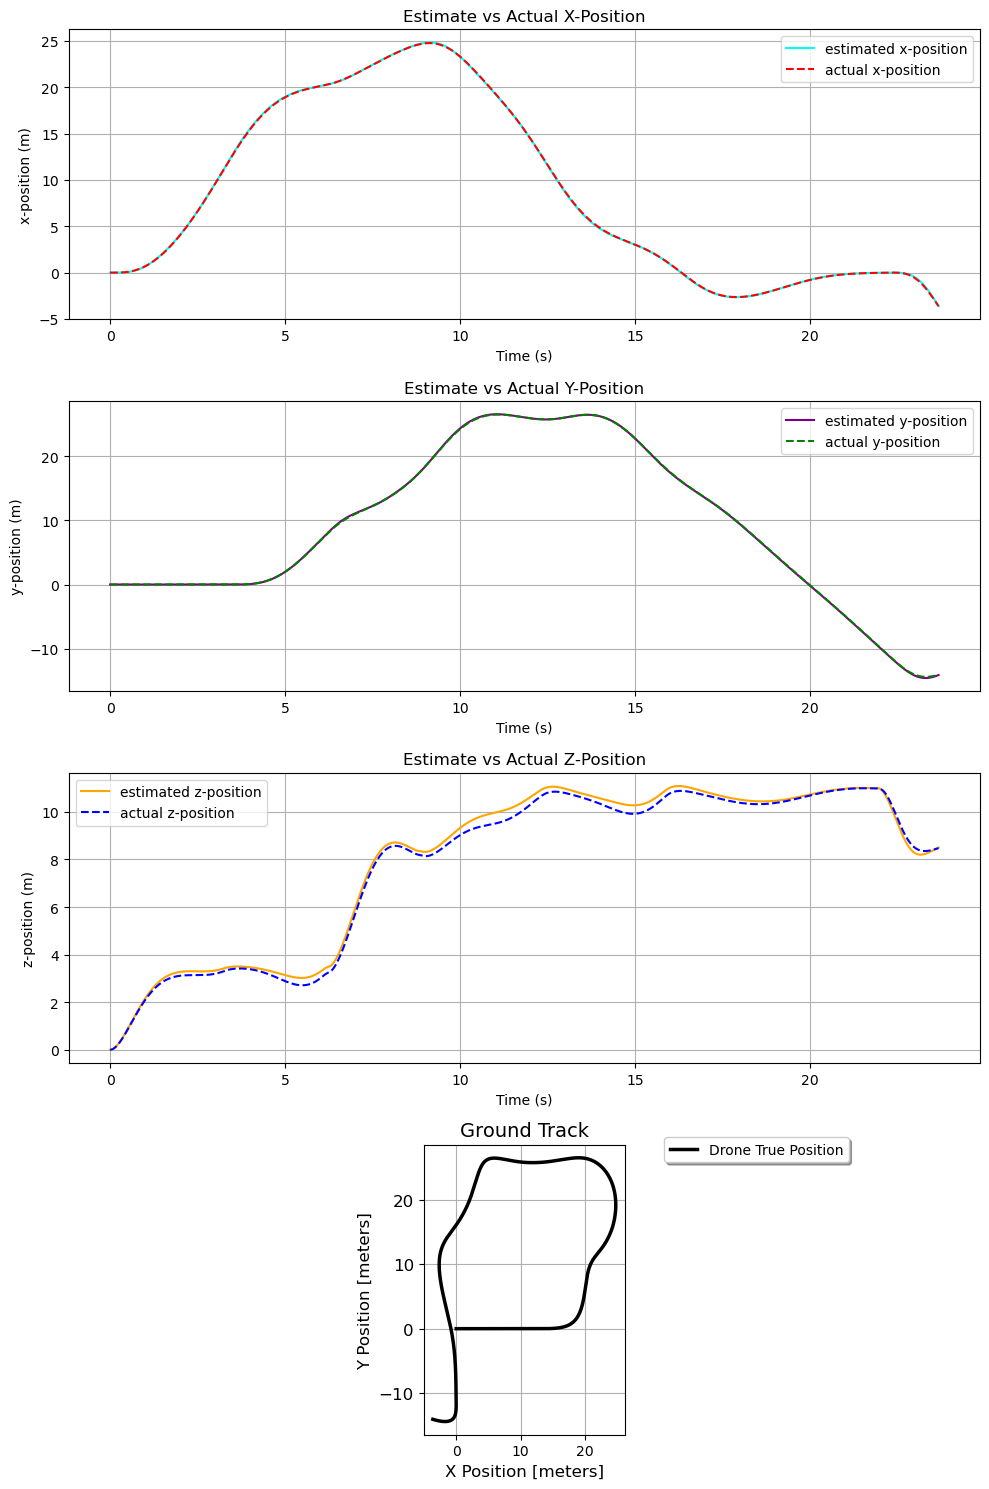

In [54]:
# Setting up the figure and subplots
fig, axs = plt.subplots(4, 1, figsize=(10, 15))

# x-position plot
axs[0].plot(time_test, x_est, label='estimated x-position', color='cyan')
axs[0].plot(time_test, x_act, label='actual x-position', color='red', linestyle='--')
axs[0].legend()
axs[0].set_title('Estimate vs Actual X-Position')
axs[0].set_xlabel('Time (s)')
axs[0].set_ylabel('x-position (m)')
axs[0].grid(True)

# y-position plot
axs[1].plot(time_test, y_est, label='estimated y-position', color='purple')
axs[1].plot(time_test, y_act, label='actual y-position', color='green', linestyle='--')
axs[1].legend()
axs[1].set_title('Estimate vs Actual Y-Position')
axs[1].set_xlabel('Time (s)')
axs[1].set_ylabel('y-position (m)')
axs[1].grid(True)

# z-position plot
axs[2].plot(time_test, z_est, label='estimated z-position', color='orange')
axs[2].plot(time_test, z_act, label='actual z-position', color='blue', linestyle='--')
axs[2].legend()
axs[2].set_title('Estimate vs Actual Z-Position')
axs[2].set_xlabel('Time (s)')
axs[2].set_ylabel('z-position (m)')
axs[2].grid(True)

# Drone True Position (X-Y) (Aerial)
axs[3].plot(x_act, y_act, c='black', lw=2.5, label="Drone True Position")
axs[3].set_xlabel("X Position [meters]", fontsize=12)
axs[3].set_ylabel("Y Position [meters]", fontsize=12)
axs[3].tick_params(axis='y', labelsize=12)
axs[3].set_title("Ground Track", fontsize=14)
axs[3].set_aspect('equal', 'box')
axs[3].legend(bbox_to_anchor=(1.16, 1.05), fancybox=True, shadow=True)
axs[3].grid()

# Adjusting layout and displaying the plots
plt.tight_layout()
plt.savefig('est-act-pos-data.png', dpi=300, bbox_inches='tight')
plt.show()

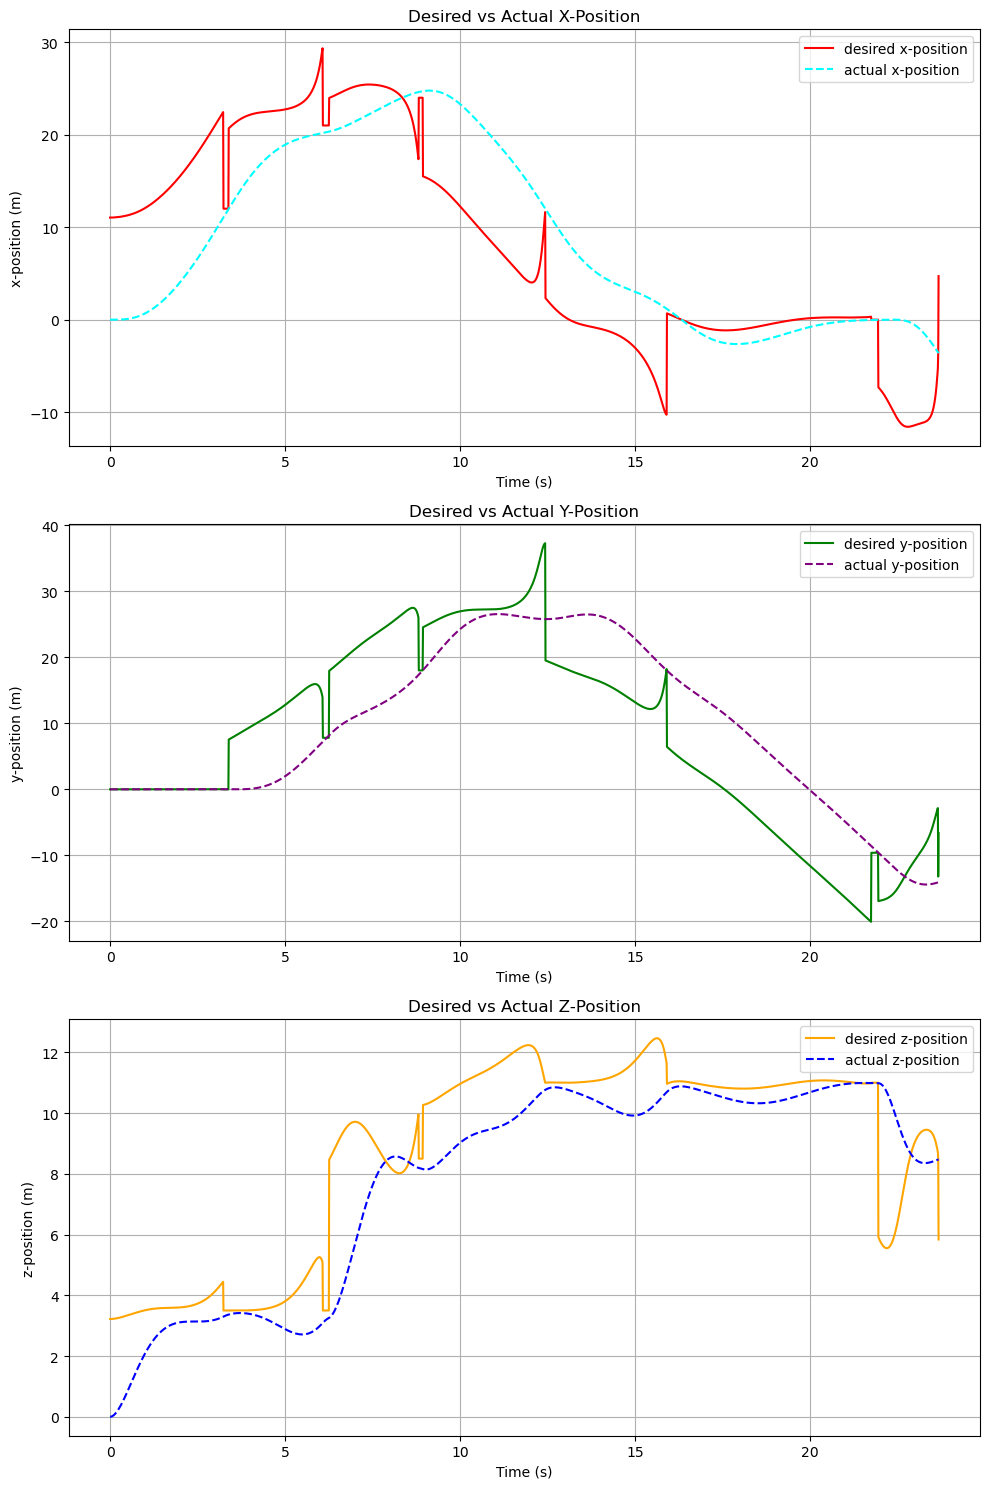

In [45]:
# Setting up the figure and subplots
fig, axs = plt.subplots(3, 1, figsize=(10, 15))

# x-position plot
axs[0].plot(time_test, x_des, label='desired x-position', color='red')
axs[0].plot(time_test, x_act, label='actual x-position', color='cyan', linestyle='--')
axs[0].legend()
axs[0].set_title('Desired vs Actual X-Position')
axs[0].set_xlabel('Time (s)')
axs[0].set_ylabel('x-position (m)')
axs[0].grid(True)

# y-position plot
axs[1].plot(time_test, y_des, label='desired y-position', color='green')
axs[1].plot(time_test, y_act, label='actual y-position', color='purple', linestyle='--')
axs[1].legend()
axs[1].set_title('Desired vs Actual Y-Position')
axs[1].set_xlabel('Time (s)')
axs[1].set_ylabel('y-position (m)')
axs[1].grid(True)

# z-position plot
axs[2].plot(time_test, z_des, label='desired z-position', color='orange')
axs[2].plot(time_test, z_act, label='actual z-position', color='blue', linestyle='--')
axs[2].legend()
axs[2].set_title('Desired vs Actual Z-Position')
axs[2].set_xlabel('Time (s)')
axs[2].set_ylabel('z-position (m)')
axs[2].grid(True)

# Adjusting layout and displaying the plots
plt.tight_layout()
plt.savefig('des-act-pos-data.png', dpi=300, bbox_inches='tight')
plt.show()

Average Simulation Run Time: 23.679600000000907


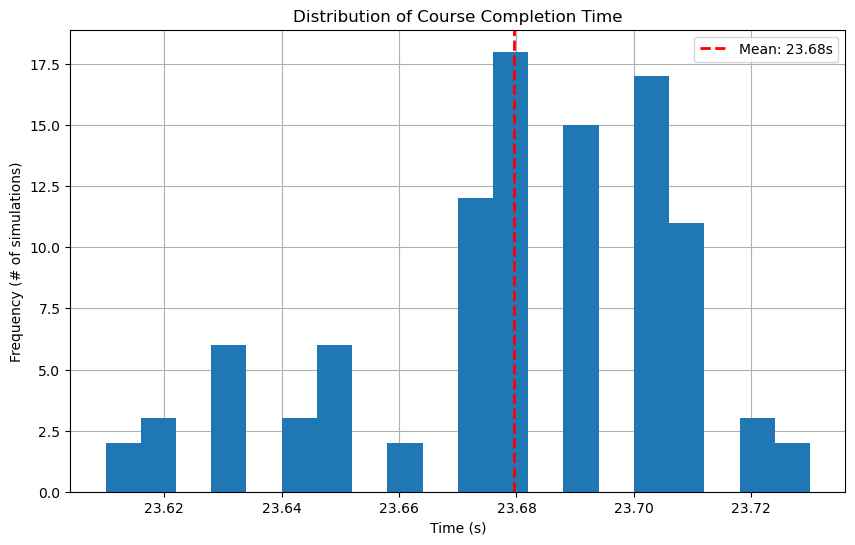

In [66]:
fig, ax = plt.subplots(figsize=(10, 6)) 

mean_time = np.mean(time)

ax.hist(time, bins=20, zorder=2)
ax.axvline(mean_time, color='r', linestyle='dashed', linewidth=2, label=f"Mean: {mean_time:.2f}s")
ax.grid(zorder=0)
ax.set_xlabel('Time (s)')
ax.set_ylabel('Frequency (# of simulations)')
ax.set_title('Distribution of Course Completion Time')
ax.legend()

print("Average Simulation Run Time:", mean_time)
plt.show()